# Film Data Analysis  -  Top Directors, Writers, Actors with respect to domesting ppratio

## Initial Setup

In [46]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.multicomp import MultiComparison
import pandas as pd

In [47]:
films = pd.read_csv('Data\\Reduced_Data\\films_2010.csv')

In [48]:
films.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63849 entries, 0 to 63848
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         63849 non-null  int64  
 1   primary_title      63849 non-null  object 
 2   year               63849 non-null  float64
 3   runtime_minutes    62741 non-null  float64
 4   genres             62322 non-null  object 
 5   movie_id           62741 non-null  object 
 6   writer             54128 non-null  object 
 7   director           62264 non-null  object 
 8   production_budget  2440 non-null   float64
 9   domestic_gross     4564 non-null   float64
 10  worldwide_gross    3372 non-null   float64
 11  studio             3381 non-null   object 
 12  foreign_gross      3398 non-null   float64
 13  averagerating      62783 non-null  float64
 14  numvotes           62779 non-null  float64
 15  log_numvotes       62115 non-null  float64
 16  actors             627

#### Get rid of what we don't need for the following analyses

In [49]:
drop_columns= ['Unnamed: 0', 'domestic_gross', 'worldwide_gross', 'foreign_gross', 'log_numvotes', 
              'ww_netprofit', 'ww_ppratio', 'f_netprofit', 'f_ppratio']
films = films.drop(drop_columns, axis=1)

#### Get rid of the null data in the financial columns

In [50]:
films = films[films.d_netprofit.notna()]

In [51]:
films.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2440 entries, 14 to 63144
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   primary_title      2440 non-null   object 
 1   year               2440 non-null   float64
 2   runtime_minutes    2036 non-null   float64
 3   genres             2035 non-null   object 
 4   movie_id           2036 non-null   object 
 5   writer             1947 non-null   object 
 6   director           2030 non-null   object 
 7   production_budget  2440 non-null   float64
 8   studio             1235 non-null   object 
 9   averagerating      2019 non-null   float64
 10  numvotes           2019 non-null   float64
 11  actors             2036 non-null   object 
 12  d_netprofit        2440 non-null   float64
 13  d_ppratio          2440 non-null   float64
dtypes: float64(7), object(7)
memory usage: 285.9+ KB


---

---

## Analyzing d_pp_ratio by director -------------------------------------------------------------------------------

#### Find the top 15 directors by mean d_ppratio, that have at least 4 films in the data

In [52]:
# top 15 directors by mean d_ppratio with at least 3 films
grouped = films.groupby('director')['d_ppratio'].agg(['mean', 'count'])
target_directors = grouped[grouped['count'] > 3].sort_values(by='mean', ascending=False).head(15).index
# create a boolean column whether the director is high or low dppratio
films_dir = films
films_dir['hi_ppratio_dir'] = films['director'].isin(target_directors)


#### Create groups for high and low d_ppratio directors and perform 2-sample t-test

In [53]:
hi_ppratio_dir = films_dir[films_dir['hi_ppratio_dir'] == True]['d_ppratio']
lo_ppratio_dir = films_dir[films_dir['hi_ppratio_dir'] == False]['d_ppratio']
stat, p = stats.ttest_ind(lo_ppratio_dir, hi_ppratio_dir)
print(f'p-value: {p}')

p-value: 0.0022138604447109215


#### <u> RESULT: Very low p-value indicates there is a significant difference between the high and low groups (which makes since because we cherry-picked the top 15)

#### Find mean diff and conf. intervals

In [54]:
desc_hi = sm.stats.DescrStatsW(hi_ppratio_dir)
desc_lo = sm.stats.DescrStatsW(lo_ppratio_dir)
compare = sm.stats.CompareMeans(desc_hi, desc_lo)
# Confidence interval for the mean difference
# Default is 95% CI, adjust with `alpha` parameter for other levels
conf_int = compare.tconfint_diff(usevar='unequal')
means_diff = hi_ppratio_dir.mean() - lo_ppratio_dir.mean()
print(f'mean difference: {means_diff}')
print(f"Confidence Interval: {conf_int}")

mean difference: 2.072598656753139
Confidence Interval: (0.8606741000517983, 3.28452321345448)


#### Show boxplot of the high and low ppratio director groups and display statistics

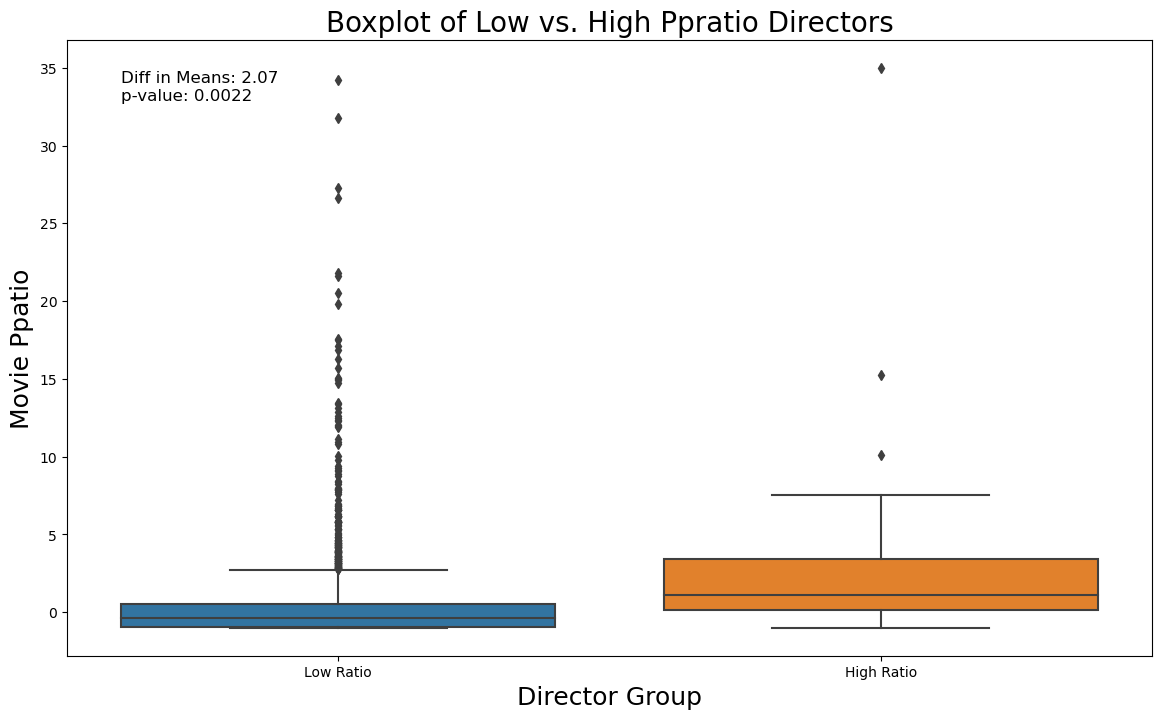

In [55]:
films_dir = films_dir.query('d_ppratio < 50') #removing extreme outliers
plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(x='hi_ppratio_dir', y='d_ppratio', data=films_dir)
boxplot.set_xticklabels(['Low Ratio', 'High Ratio'])
plt.text(0.05, 0.95, f'Diff in Means: {means_diff:.2f}\np-value: {p:.2g}', 
         ha='left', va='top', transform=plt.gca().transAxes, fontsize=12)
plt.title('Boxplot of Low vs. High Ppratio Directors', fontsize=20)
plt.xlabel('Director Group', fontsize=18)
plt.ylabel('Movie Ppatio', fontsize=18)
plt.show()

#### Save the boxplot as a transparent image with white text for visualizations

In [56]:
# Save the boxplot as an image, formatted for powerpoint presentation
sns.set(style='white', rc={'axes.edgecolor': 'none', 'grid.color': 'none', 
                           'text.color': 'white', 'axes.labelcolor': 'white', 
                           'xtick.color': 'white', 'ytick.color': 'white', 'axes.grid': False})

plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(x='hi_ppratio_dir', y='d_ppratio', data=films_dir, palette='Set2')

# Set the labels with white text and good font sizes
boxplot.set_xticklabels(['Low Ratio', 'High Ratio'], fontsize=18)
boxplot.set_title('Boxplot of Low vs. High Ppratio Directors', fontsize=20)
boxplot.set_xlabel('Director Group', fontsize=18)
boxplot.set_ylabel('Movie Ppratio', fontsize=18)

# Add stats info text inside the plot with white text and good font sizes
plt.text(0.05, 0.95, f'Diff in Means: {means_diff:.2f}\np-value: {p:.2g}', 
         ha='left', va='top', transform=plt.gca().transAxes, fontsize=14)


# Save the figure with a transparent background
plt.savefig('boxplot_directors.png', bbox_inches='tight', transparent=True)
plt.close()   # dont want to see the graph displayed below, just save the image
sns.reset_defaults()  #so the next graph displays correctly

#### Pair down the data set to only the high ppratio directors for graphing purposes

In [57]:
films_dir = films_dir[films_dir['hi_ppratio_dir'] == True]

#### Display a strip plot of movie ppratio for the top 15 directors

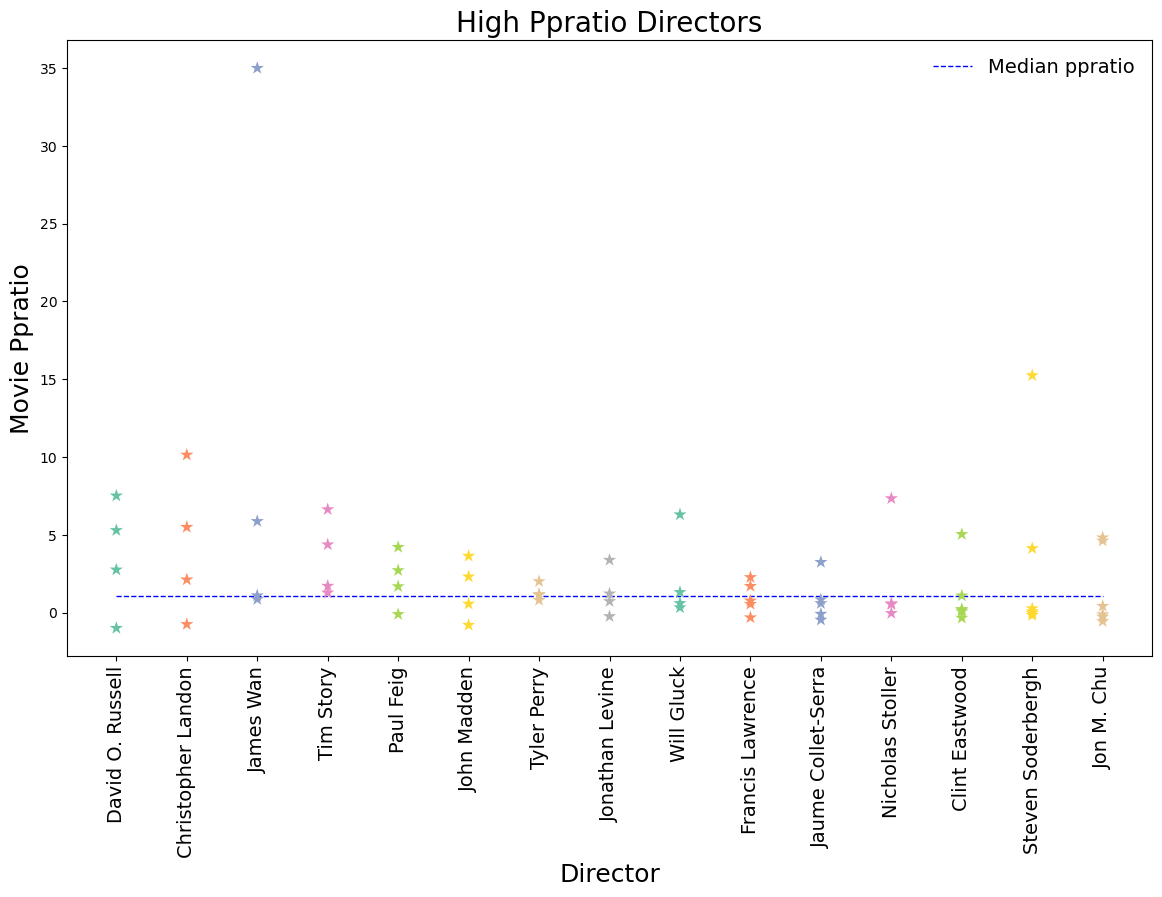

In [58]:
medians = films_dir.groupby('director')['d_ppratio'].median().sort_values(ascending=False)

# Reorder the original DataFrame based on the sorted medians
films_dir_sorted = films_dir.set_index('director').loc[medians.index].reset_index()

# Plot the stripplot using the reordered DataFrame
plt.figure(figsize=(14, 8))
stripplot = sns.stripplot(x='director', y='d_ppratio', data=films_dir_sorted, jitter=False, 
              palette='Set2', size=10, marker='*', hue='director', legend=False)

plt.hlines(y=films_dir.d_ppratio.median(), xmin=0, xmax=14, 
           colors='blue', linestyles='dashed', lw=1, label='Median ppratio')

# Add legend, rotate x-ticks and show the plot
plt.title('High Ppratio Directors', fontsize=20)
plt.xlabel('Director', fontsize=18)
plt.ylabel('Movie Ppratio', fontsize=18)
legend = stripplot.legend(frameon=True, framealpha=0.0, fontsize=14)  # framealpha=0.0 makes the legend box transparent
plt.xticks(rotation=90, fontsize=14)
plt.show()

#### Save the Strip plot as a transparent image with white text for visualizations

In [59]:
sns.set(style='white', rc={'axes.edgecolor': 'none', 'grid.color': 'none', 
                           'text.color': 'white', 'axes.labelcolor': 'white', 
                           'xtick.color': 'white', 'ytick.color': 'white', 'axes.grid': False})

medians = films_dir.groupby('director')['d_ppratio'].median().sort_values(ascending=False)

# Reorder the original DataFrame based on the sorted medians
films_dir_sorted = films_dir.set_index('director').loc[medians.index].reset_index()

# Plot the boxplot using the reordered DataFrame
plt.figure(figsize=(14, 8))

#Create the strip plot
stripplot = sns.stripplot(x='director', y='d_ppratio', data=films_dir_sorted, jitter=False, 
              palette='Set2', size=10, marker='*', hue='director', legend=False)

#create the median line
plt.hlines(y=films_dir.d_ppratio.median(), xmin=0, xmax=14, 
           colors='lightblue', linestyles='dashed', lw=1, label='Median ppratio')

# Add legend, rotate x-ticks and show the plot
plt.title('High Ppratio Directors', fontsize=20)
plt.xlabel('Director', fontsize=18)
plt.ylabel('Movie Ppratio', fontsize=18)
legend = stripplot.legend(frameon=True, framealpha=0.0, fontsize=14)  # framealpha=0.0 makes the legend box transparent
plt.xticks(rotation=90, fontsize=14)
# Save the figure with a transparent background
plt.savefig('stripplot_directors.png', bbox_inches='tight', transparent=True)
plt.close()   # dont want to see the graph displayed below, just save the image
sns.reset_defaults()  #so the next graph displays correctly

---

---

## Analyzing d_pp_ratio by writer -------------------------------------------------------------------------------

#### Breaking the data down here becomes trickier as there are multiple writers possible per film.  Will explode the df such that there is a row for each writer per movie

In [60]:
# get rid of null values in the writer column
films_writer = films[films['writer'].notna()]
# create the exploded df by writer, pulling each comma separated writer out of the writer column
df_exploded = films_writer.assign(writer=films_writer['writer'].str.split(',')).explode('writer')

# Strip whitespace from the writer names
df_exploded['writer'] = df_exploded['writer'].str.strip()

# Group by the writer names and aggregate by dppratio mean and count
writers = df_exploded.groupby('writer').agg(
    mean_ppratio=('d_ppratio', 'mean'),
    count=('d_ppratio', 'size')
).reset_index()

# The result is a DataFrame with the mean ppratio for each writer
writers = writers[writers['count'] > 3]  # must have at least 4 films for significance
writers = writers.sort_values(by='mean_ppratio', ascending=False).head(15)
writer_names = writers.writer.tolist()  #also create a list of the top 15 for future filtering
writers

,writer,mean_ppratio,count
2407,Oren Peli,11.325734,7
601,Christopher Landon,10.615487,6
1293,James DeMonaco,9.672991,4
673,Damien Chazelle,6.433448,4
936,Eli Roth,4.589548,4
2830,Scott Derrickson,4.308063,4
2204,Michael H. Weber,3.481493,4
2842,Scott Neustadter,3.481493,4
1784,Ken Daurio,2.728770,5
619,Cinco Paul,2.728770,5


#### We need to create a boolean column in the full film df to identify if a top writer was on the film

In [61]:
def is_hi_ppratio_writer(row, writers_list):
    # Check if the row is a string instance to avoid AttributeError
    if isinstance(row, str):
        # Split the 'writer' column by commas and strip whitespace
        writers_in_row = [name.strip() for name in row.split(',')]
        # Check if any writer in the row is in the provided list
        return any(writer in writers_list for writer in writers_in_row)
    else:
        # If the row is not a string, return False or handle as needed
        return False

# Apply the function to each row in the 'writer' column
films_writers = films
films_writers['hi_ppratio_writer'] = films_writers['writer'].apply(is_hi_ppratio_writer, writers_list=writer_names)
films_writers = films_writers[films_writers['writer'].notna()]

#### Create test groups and do t-test

In [62]:
hi_ppratio_writer = films_writers[films_writers['hi_ppratio_writer'] == True]['d_ppratio']
lo_ppratio_writer = films_writers[films_writers['hi_ppratio_writer'] == False]['d_ppratio']
stat, p = stats.ttest_ind(lo_ppratio_writer, hi_ppratio_writer)
print(f'p-value: {p}')

p-value: 4.5400541117773817e-07


#### <u> RESULT: Very low p-value indicates there is a significant difference between the high and low groups (which makes since because we cherry-picked the top 15)

#### Find the difference in means and confidence interval

In [63]:
#### Create test groups and do t-testdesc_hi = sm.stats.DescrStatsW(hi_ppratio_writer)
desc_lo = sm.stats.DescrStatsW(lo_ppratio_writer)
compare = sm.stats.CompareMeans(desc_hi, desc_lo)
# Confidence interval for the mean difference
# Default is 95% CI, adjust with `alpha` parameter for other levels
conf_int = compare.tconfint_diff(usevar='unequal')
means_diff = hi_ppratio_writer.mean() - lo_ppratio_writer.mean()
print(f'mean difference: {hi_ppratio_writer.mean() - lo_ppratio_writer.mean()}')
print(f"Confidence Interval: {conf_int}")

mean difference: 4.145234728460186
Confidence Interval: (0.789584990886169, 3.2309169098888617)


#### Show boxplot of the high and low ppratio writer groups and display statistics

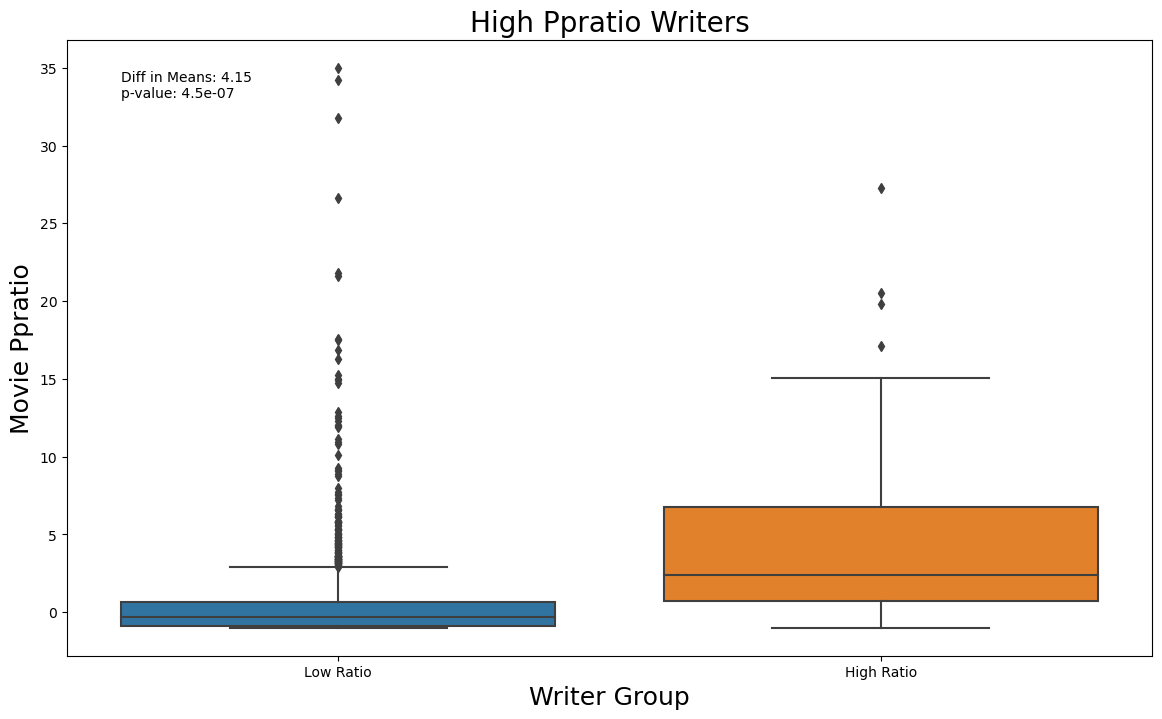

In [64]:
films_writers = films_writers.query('d_ppratio < 50')
plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(x='hi_ppratio_writer', y='d_ppratio', data=films_writers)
boxplot.set_xticklabels(['Low Ratio', 'High Ratio'])
#plt.hlines(y=films.d_ppratio.median(), xmin=0, xmax=1, 
#           colors='blue', linestyles='dashed', lw=1, label='median d_ppratio')
plt.text(0.05, 0.95, f'Diff in Means: {means_diff:.2f}\np-value: {p:.2g}', 
         ha='left', va='top', transform=plt.gca().transAxes)
plt.title('High Ppratio Writers', fontsize=20)
plt.xlabel('Writer Group', fontsize=18)
plt.ylabel('Movie Ppratio', fontsize=18)

#plt.legend()
#plt.xticks(rotation=90)
plt.show()

In [65]:
sns.set(style='white', rc={'axes.edgecolor': 'none', 'grid.color': 'none', 
                           'text.color': 'white', 'axes.labelcolor': 'white', 
                           'xtick.color': 'white', 'ytick.color': 'white', 'axes.grid': False})

plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(x='hi_ppratio_writer', y='d_ppratio', data=films_writers, palette='Set2')

# Set the labels with white text
boxplot.set_xticklabels(['Low Ratio', 'High Ratio'], fontsize=18)
boxplot.set_title('Boxplot of Low vs. High Ppratio Writers', fontsize=20)
boxplot.set_xlabel('Writer Group', fontsize=18)
boxplot.set_ylabel('Movie Ppratio', fontsize=18)

# Add text inside the plot with white text
plt.text(0.05, 0.95, f'Diff in Means: {means_diff:.2f}\np-value: {p:.2g}', 
         ha='left', va='top', transform=plt.gca().transAxes, fontsize=14)

# Save the figure with a transparent background
plt.savefig('boxplot_writers.png', bbox_inches='tight', transparent=True)
plt.close()   # dont want to see the graph displayed below, just save the image
sns.reset_defaults()  #so the next graph displays correctly

In [66]:
top_writers = pd.DataFrame(columns=['writer', 'd_ppratio'])
for index, row in films_writers.iterrows():
    # Split the 'x' column by any separators if necessary and check for names
    for name in writer_names:
        if name in row['writer']:
            # If a name is found, append it and the ppratio value to the new DataFrame
            top_writers = top_writers.append({'writer': name, 'd_ppratio': row['d_ppratio']}, ignore_index=True)
top_writers

,writer,d_ppratio
0,Stephen King,1.605938
1,Damien Chazelle,13.416600
2,Scott Derrickson,0.409951
3,Jonah Hill,2.296373
4,Stephen Susco,-0.986097
...,...,...
62,Jonah Hill,0.587468
63,Stephen Susco,7.866745
64,James DeMonaco,4.345288
65,Ryan Engle,6.806765


<Figure size 1400x800 with 0 Axes>

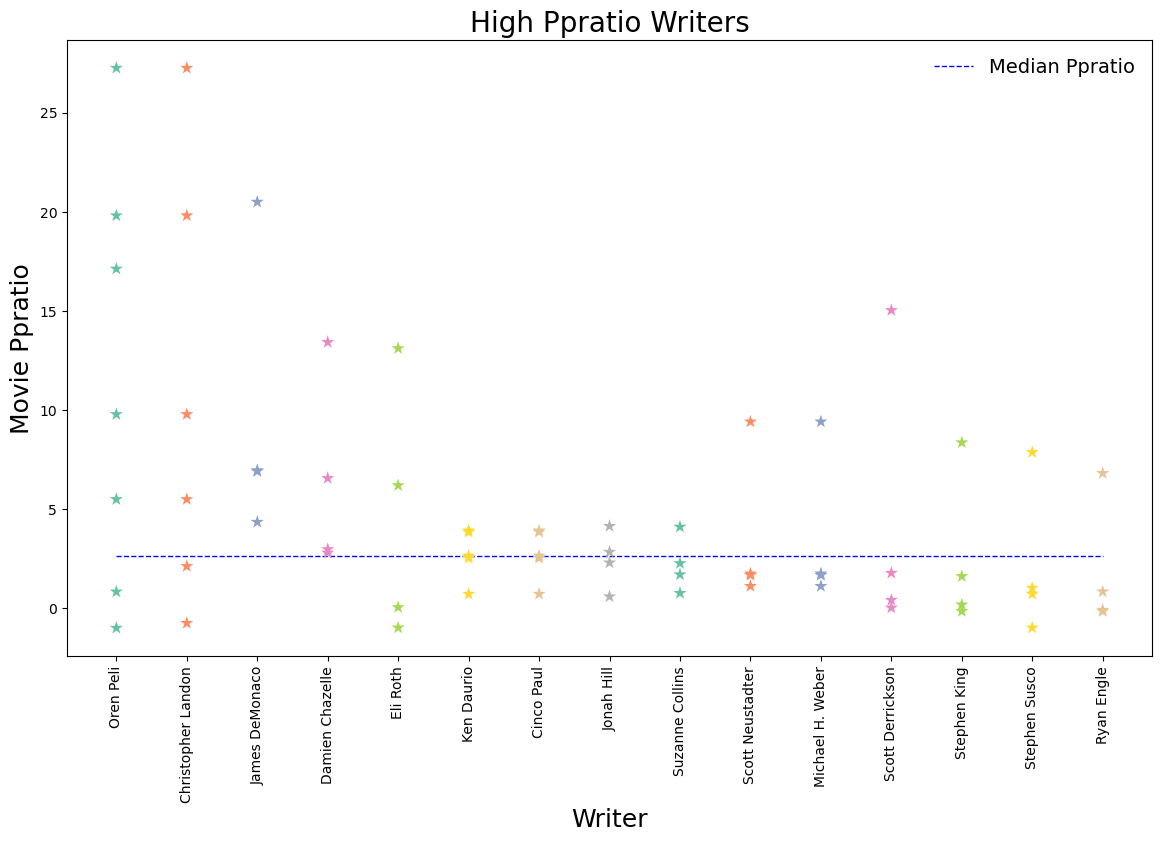

In [67]:
plt.figure(figsize=(14, 8))
medians = top_writers.groupby('writer')['d_ppratio'].median().sort_values(ascending=False)
top_writers_sorted = top_writers.set_index('writer').loc[medians.index].reset_index()
plt.figure(figsize=(14, 8))
#sns.boxplot(x='writer', y='d_ppratio', data=top_writers_sorted)
stripplot = sns.stripplot(x='writer', y='d_ppratio', data=top_writers_sorted, jitter=False, 
              palette='Set2', size=10, marker='*', hue='writer', legend=False)
# Add a horizontal line for the overall median
plt.hlines(y=top_writers.d_ppratio.median(), xmin=0, xmax=14, 
           colors='blue', linestyles='dashed', lw=1, label='Median Ppratio')

# Add legend, rotate x-ticks and show the plot
legend = stripplot.legend(frameon=True, framealpha=0.0, fontsize=14)  # framealpha=0.0 makes the legend box transparent
#plt.legend()
plt.title('High Ppratio Writers', fontsize=20)
plt.xlabel('Writer', fontsize=18)
plt.ylabel('Movie Ppratio', fontsize=18)
plt.xticks(rotation=90)
plt.show();

In [68]:
sns.set(style='white', rc={'axes.edgecolor': 'none', 'grid.color': 'none', 
                           'text.color': 'white', 'axes.labelcolor': 'white', 
                           'xtick.color': 'white', 'ytick.color': 'white', 'axes.grid': False})

# Plot the boxplot using the reordered DataFrame
plt.figure(figsize=(14, 8))

#Create the strip plot
stripplot = sns.stripplot(x='writer', y='d_ppratio', data=top_writers_sorted, jitter=False, 
              palette='Set2', size=10, marker='*', hue='writer', legend=False)

#create the median line
plt.hlines(y=top_writers.d_ppratio.median(), xmin=0, xmax=14, 
           colors='lightblue', linestyles='dashed', lw=1, label='Median Ppratio')

# Add legend, rotate x-ticks and show the plot
plt.title('High Ppratio Writers', fontsize=20)
plt.xlabel('Writer', fontsize=18)
plt.ylabel('Movie Ppratio', fontsize=18)
legend = stripplot.legend(frameon=True, framealpha=0.0, fontsize=14)  # framealpha=0.0 makes the legend box transparent
plt.xticks(rotation=90, fontsize=14)
# Save the figure with a transparent background
plt.savefig('stripplot_writers.png', bbox_inches='tight', transparent=True)
plt.close()   # dont want to see the graph displayed below, just save the image
sns.reset_defaults()  #so the next graph displays correctly

---

---

## Analyzing d_pp_ratio by actor

In [69]:
films_actors = films[films['actors'].notna()]
df_exploded = films_actors.assign(actors=films_actors['actors'].str.split(',')).explode('actors')

# Step 2: Strip whitespace from the writer names
df_exploded['actors'] = df_exploded['actors'].str.strip(" '\"[]")
df_exploded['actors'] = df_exploded['actors'].str.title()

# Step 3: Group by the writer names and calculate the mean of 'y'
actors = df_exploded.groupby('actors').agg(
    mean_ppratio=('d_ppratio', 'mean'),
    count=('d_ppratio', 'size')
).reset_index()

# The result is a DataFrame with the mean 'y' for each writer
actors = actors[actors['count'] > 3]
actors = actors.sort_values(by='mean_ppratio', ascending=False).head(15)
actors

,actors,mean_ppratio,count
3272,Octavia Spencer,6.426386,5
676,Catherine Keener,6.018481,6
3673,Rose Byrne,5.387734,9
1325,Ethan Hawke,5.147261,8
2729,Mahershala Ali,4.797368,4
2971,Michael B. Jordan,4.468320,6
3345,Patrick Wilson,4.411012,9
3160,Naomie Harris,4.292865,4
1424,Gabrielle Union,4.063752,4
3292,Olivia Munn,3.652625,4


In [70]:
actor_names = actors.actors.tolist()
actor_names

['Octavia Spencer',
 'Catherine Keener',
 'Rose Byrne',
 'Ethan Hawke',
 'Mahershala Ali',
 'Michael B. Jordan',
 'Patrick Wilson',
 'Naomie Harris',
 'Gabrielle Union',
 'Olivia Munn',
 'Lena Headey',
 'Frank Grillo',
 'Mary Elizabeth Winstead',
 'John Corbett',
 'Michael Ealy']

In [71]:
def is_hi_ppratio_actor(row, actors_list):
    # Check if the row is a string instance to avoid AttributeError
    if isinstance(row, str):
        # Split the 'actors' column by commas and strip whitespace and quotes
        actors_in_row = [name.strip(" '\"[]") for name in row.split(',')]
        # Check if any actor in the row is in the provided list
        return any(actor in actors_list for actor in actors_in_row)
    else:
        # If the row is not a string, return False or handle as needed
        return False

# Apply the function to each row in the 'actors' column
films_actors = films
films_actors['hi_ppratio_actor'] = films_actors['actors'].apply(is_hi_ppratio_actor, actors_list=actor_names)

In [72]:
hi_ppratio_actor = films_actors[films_actors['hi_ppratio_actor'] == True]['d_ppratio']
lo_ppratio_actor = films_actors[films_actors['hi_ppratio_actor'] == False]['d_ppratio']
stat, p = stats.ttest_ind(lo_ppratio_actor, hi_ppratio_actor)
print(f'p-value: {p}')

p-value: 1.1522324692912337e-06


#### <u> RESULT: Very low p-value indicates there is a significant difference between the high and low groups (which makes sense because we cherry-picked the top 15)

In [73]:
desc_hi = sm.stats.DescrStatsW(hi_ppratio_actor)
desc_lo = sm.stats.DescrStatsW(lo_ppratio_actor)
compare = sm.stats.CompareMeans(desc_hi, desc_lo)
# Confidence interval for the mean difference
# Default is 95% CI, adjust with `alpha` parameter for other levels
conf_int = compare.tconfint_diff(usevar='unequal')
means_diff = hi_ppratio_actor.mean() - lo_ppratio_actor.mean()
print(f'mean difference: {hi_ppratio_actor.mean() - lo_ppratio_actor.mean()}')
print(f"Confidence Interval: {conf_int}")

mean difference: 3.1573362171092634
Confidence Interval: (1.5081371572077191, 4.806535277010808)


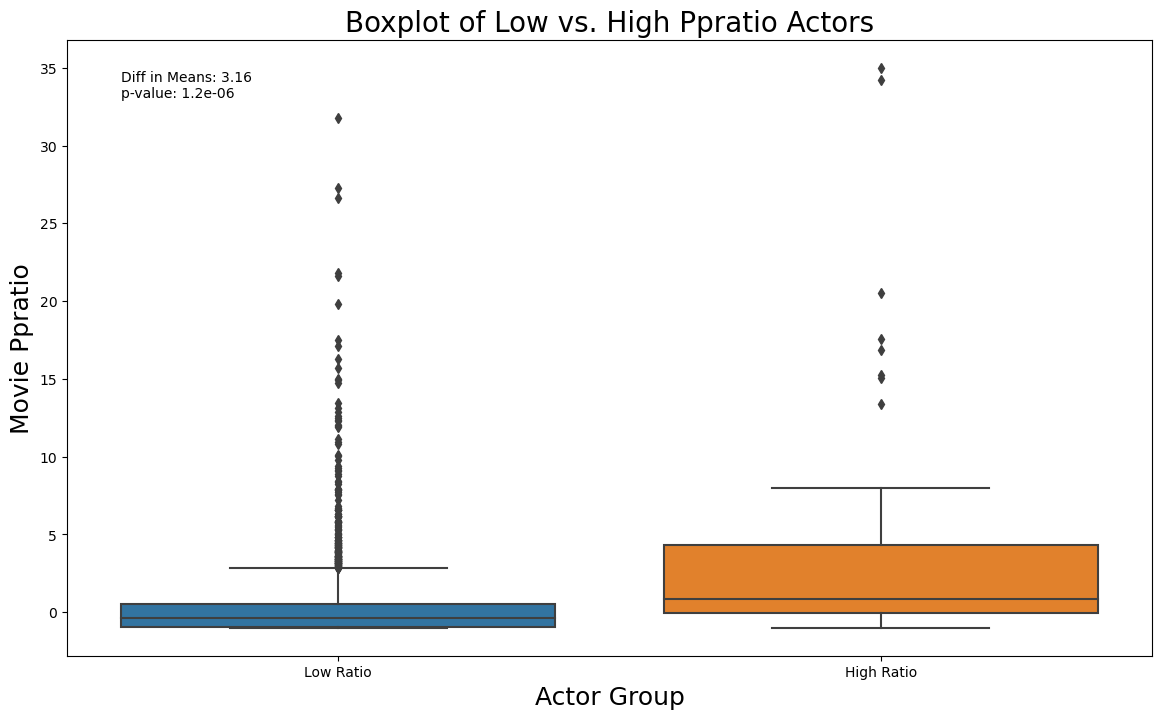

In [74]:
films_actors = films_actors.query('d_ppratio < 50')
plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(x='hi_ppratio_actor', y='d_ppratio', data=films_actors)
boxplot.set_xticklabels(['Low Ratio', 'High Ratio'])
plt.text(0.05, 0.95, f'Diff in Means: {means_diff:.2f}\np-value: {p:.2g}', 
         ha='left', va='top', transform=plt.gca().transAxes)
plt.title('Boxplot of Low vs. High Ppratio Actors', fontsize=20)
plt.xlabel('Actor Group', fontsize=18)
plt.ylabel('Movie Ppratio', fontsize=18)
plt.show()

In [75]:
sns.set(style='white', rc={'axes.edgecolor': 'none', 'grid.color': 'none', 
                           'text.color': 'white', 'axes.labelcolor': 'white', 
                           'xtick.color': 'white', 'ytick.color': 'white', 'axes.grid': False})

plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(x='hi_ppratio_actor', y='d_ppratio', data=films_actors, palette='Set2')

# Set the labels with white text
boxplot.set_xticklabels(['Low Ratio', 'High Ratio'], fontsize=18)
boxplot.set_title('Boxplot of Low vs. High Ppratio Actors', fontsize=20)
boxplot.set_xlabel('Actor Group', fontsize=18)
boxplot.set_ylabel('Movie Ppratio', fontsize=18)

# Add text inside the plot with white text
plt.text(0.05, 0.95, f'Diff in Means: {means_diff:.2f}\np-value: {p:.2g}', 
         ha='left', va='top', transform=plt.gca().transAxes, fontsize=14)

# Save the figure with a transparent background
plt.savefig('boxplot_actors.png', bbox_inches='tight', transparent=True)
plt.close()   # dont want to see the graph displayed below, just save the image
sns.reset_defaults()  #so the next graph displays correctly

In [76]:
films_actors = films_actors[films_actors['hi_ppratio_actor'] == True]

In [77]:
top_actors = pd.DataFrame(columns=['actor', 'd_ppratio'])
for index, row in films_actors.iterrows():
    # Split the 'x' column by any separators if necessary and check for names
    for name in actor_names:
        if name in row['actors']:
            # If a name is found, append it and the 'y' value to the new DataFrame
            top_actors = top_actors.append({'actor': name, 'd_ppratio': row['d_ppratio']}, ignore_index=True)
top_actors

,actor,d_ppratio
0,Mahershala Ali,-0.495822
1,Catherine Keener,0.386433
2,Patrick Wilson,-1.000000
3,John Corbett,0.744467
4,Catherine Keener,0.344525
...,...,...
75,Ethan Hawke,-0.014784
76,Michael B. Jordan,1.314318
77,Mahershala Ali,2.699138
78,Gabrielle Union,6.806765


<Figure size 1400x800 with 0 Axes>

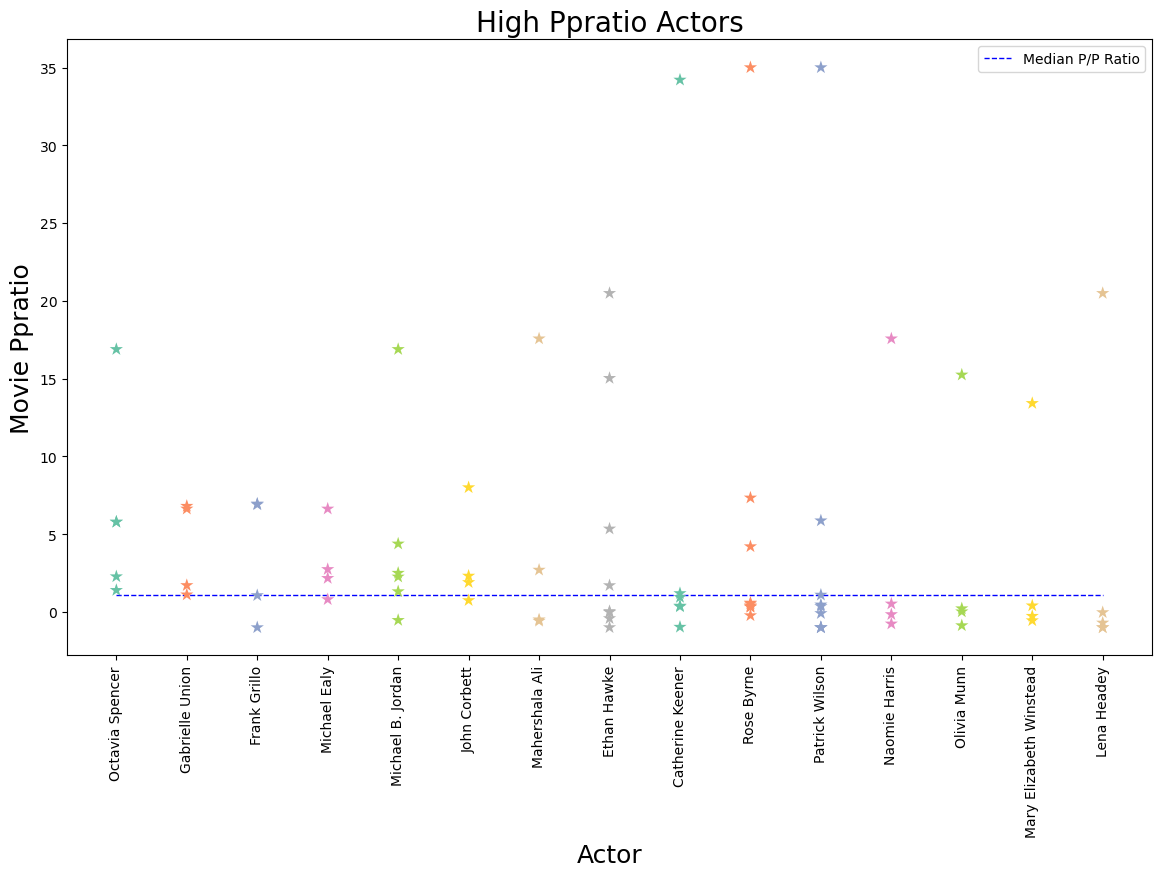

In [78]:
plt.figure(figsize=(14, 8))
medians = top_actors.groupby('actor')['d_ppratio'].median().sort_values(ascending=False)
top_actors_sorted = top_actors.set_index('actor').loc[medians.index].reset_index()
plt.figure(figsize=(14, 8))

sns.stripplot(x='actor', y='d_ppratio', data=top_actors_sorted, jitter=False, 
              palette='Set2', size=10, marker='*', hue='actor', legend=False)
plt.hlines(y=top_actors.d_ppratio.median(), xmin=0, xmax=14, 
           colors='blue', linestyles='dashed', lw=1, label='Median P/P Ratio')
plt.title('High Ppratio Actors', fontsize=20)
plt.xlabel('Actor', fontsize=18)
plt.ylabel('Movie Ppratio', fontsize=18)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [79]:
sns.set(style='white', rc={'axes.edgecolor': 'none', 'grid.color': 'none', 
                           'text.color': 'white', 'axes.labelcolor': 'white', 
                           'xtick.color': 'white', 'ytick.color': 'white', 'axes.grid': False})

# Plot the boxplot using the reordered DataFrame
plt.figure(figsize=(14, 8))

#Create the strip plot
sns.stripplot(x='actor', y='d_ppratio', data=top_actors_sorted, jitter=False, 
              palette='Set2', size=10, marker='*', hue='actor', legend=False)

#create the median line
plt.hlines(y=top_actors.d_ppratio.median(), xmin=0, xmax=14, 
           colors='lightblue', linestyles='dashed', lw=1, label='Median Ppratio')

# Add legend, rotate x-ticks and show the plot
plt.title('High Ppratio Actors', fontsize=20)
plt.xlabel('Actor', fontsize=18)
plt.ylabel('Movie Ppratio', fontsize=18)
legend = stripplot.legend(frameon=True, framealpha=0.0, fontsize=14)  # framealpha=0.0 makes the legend box transparent
plt.xticks(rotation=90, fontsize=14)
# Save the figure with a transparent background
plt.savefig('stripplot_actors.png', bbox_inches='tight', transparent=True)
plt.close()   # dont want to see the graph displayed below, just save the image
sns.reset_defaults()  #so the next graph displays correctly

---

---